# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = '../data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
# your code here
words = np.sort(data['Word'].unique()).tolist()
words.append('ENDPAD')
n_words = len(words)

len(data), len(words), words[-1]

(1048575, 35179, 'ENDPAD')

In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
# your code here
tags = np.sort(data['Tag'].unique()).tolist()
tags.append('PAD')
n_tags = len(tags)

len(data), len(tags), tags[-1]

(1048575, 18, 'PAD')

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)

18


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [10]:
# your code here
sentences = []
sentence = []
print(type(sentence))

sentencenum = data.iloc[0]['Sentence #']
print(sentencenum)

for i in data.itertuples():
    if sentencenum == i[1]:
        t = (i[2],i[4] )
        sentence.append(t)
    else:
        sentences.append(sentence)
        sentencenum = i[1]
        sentence = []
        t = (i[2],i[4] )
        sentence.append(t)
    
print(sentences[1])  

<class 'list'>
Sentence: 1
[('Families', 'O'), ('of', 'O'), ('soldiers', 'O'), ('killed', 'O'), ('in', 'O'), ('the', 'O'), ('conflict', 'O'), ('joined', 'O'), ('the', 'O'), ('protesters', 'O'), ('who', 'O'), ('carried', 'O'), ('banners', 'O'), ('with', 'O'), ('such', 'O'), ('slogans', 'O'), ('as', 'O'), ('"', 'O'), ('Bush', 'B-per'), ('Number', 'O'), ('One', 'O'), ('Terrorist', 'O'), ('"', 'O'), ('and', 'O'), ('"', 'O'), ('Stop', 'O'), ('the', 'O'), ('Bombings', 'O'), ('.', 'O'), ('"', 'O')]


**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [11]:
# your code here
sentlen = []
for i in sentences:
    sentlen.append(len(i))
max_len = max(sentlen)

In [12]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [13]:
# your code here
word2idx = dict()
idx2word = dict()
for word in words:
    idx2word[len(word2idx)] = word
    word2idx[word] = len(word2idx)

print(word2idx['ENDPAD'])

35178


**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [14]:
# your code here
X =[]
for i in sentences:
    w =  [word2idx[j[0]] for j in i]
    X.append(w)

print(X[10])

[15029, 32402, 34920, 17265, 33246, 22743, 33464, 27848, 17837, 23544, 18978, 24]


**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [15]:
# your code here
X = pad_sequences(X, maxlen=max_len, padding = 'post', value = word2idx['ENDPAD'], dtype='int' )

print(X[10])

[15029 32402 34920 17265 33246 22743 33464 27848 17837 23544 18978    24
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]


In [16]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 6283 27700 31967 25619 24853 33246 19981 25517 33246 29399 34878 19044
 18095 34971 32712 31830 17742     1  4114 11464 11631 14985     1 17364
     1 14484 33246  3881    24     1 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47958, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [17]:
# your code here
tag2idx = dict()
idx2tag = dict()
for tag in tags:
    idx2tag[len(tag2idx)] = tag
    tag2idx[tag] = len(tag2idx)

print(tag2idx['PAD'])

17


**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [18]:
# your code here
Y =[]
for i in sentences:
    t =  [tag2idx[j[1]] for j in i]
    Y.append(t)

print(Y[12])

[3, 16, 16, 6, 14, 14, 16, 7, 16, 3, 16, 16, 16, 16, 3, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 3, 16, 16]


**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [19]:
# your code here
Y = pad_sequences(Y, maxlen=max_len, padding = 'post', value = tag2idx['PAD'], dtype='int' )

print(Y[10])

[16 16 16 16 16 16 16 16 16 16 16 16 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17
 17 17 17 17 17 17 17 17]


**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [20]:
# your code here
Y = to_categorical(Y)

print(Y.shape)

(47958, 104, 18)


In [21]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47958, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [22]:
# your code here
np.random.seed(123)
tf.random.set_seed(456)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [23]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("../models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("../models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [24]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('../models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("../models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [25]:
# your code here
dX = []
for x in x_train:
    for j in x:
        dX.append(j)

dY=[]
for y in y_train:
    z = np.where(y == 1)[1]
    for e in z:
        dY.append(e)

d = {'w':dX,'t':dY}
XY = pd.DataFrame(d)

baseline = np.empty(n_words, dtype = int)
for w in range(n_words):
    wrows = XY.loc[XY['w'] == w]
    m = wrows.loc[:,"t"].mode()
    if len(m) > 0:
        baseline[w] = int(m[0])
    else:   
        baseline[w] = int(XY.t[w])

#print(baseline)

In [26]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47958, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [27]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [28]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# Train model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38845 samples, validate on 4317 samples
Epoch 1/10
38845/38845 [==============================] - 20s 508us/sample - loss: 0.3146 - accuracy: 0.9788 - val_loss: 0.0608 - val_accuracy: 0.9856
Epoch 2/10
38845/38845 [==============================] - 17s 444us/sample - loss: 0.0512 - accuracy: 0.9864 - val_loss: 0.0489 - val_accuracy: 0.9867
Epoch 3/10
38845/38845 [==============================] - 18s 454us/sample - loss: 0.0448 - accuracy: 0.9873 - val_loss: 0.0463 - val_accuracy: 0.9871
Epoch 4/10
38845/38845 [==============================] - 18s 455us/sample - loss: 0.0426 - accuracy: 0.9878 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 5/10
38845/38845 [==============================] - 17s 449us/sample - loss: 0.0412 - accuracy: 0.9882 - val_loss: 0.0442 - val_accuracy: 0.9877
Epoch 6/10
38845/38845 [==============================] - 17s 447us/sample - loss: 0.0404 - accuracy: 0.9884 - val_loss: 0.0437 - val_accuracy: 0.9879
Epoch 7/10
38845/38845 [=====================

In [31]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


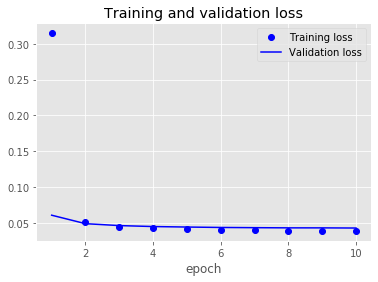

In [32]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">The embedding layer provides us a dense representation of words and their relative meanings. The word representation can be learned as part of fitting a neural network on text data. We use it here because we are trying to determine the part-of-speech for each word based on their relative position in the sentence. This is represented by the tag stored for each word.</p>
<p style="text-indent: 25px;"></p>
</font>

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">It is the number of words (35178) multiplied by the embedding dimensions (50), creating a fully connected network, plus a bias for each embedded dimension (50).</p>
<p style="text-indent: 25px;">35178 * 50 + 50 = 1758950</p>
<p style="text-indent: 25px;"></p>
</font>

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [33]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(x_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9360020061126133


In [34]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    #category = np.argmax(y_test, axis=1)
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B, 0], pca_result[indices_B, 1], label=idx2tag[cat], s=2, color=color[cat], alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

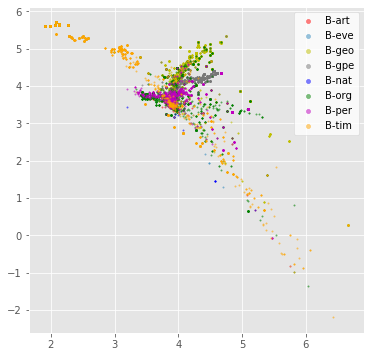

In [35]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [36]:
def get_hidden_output_PCA(model,x_test,y_test,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([x_test]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [37]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    #category = np.argmax(y_test, axis=1)
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices, 0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9360027318815594


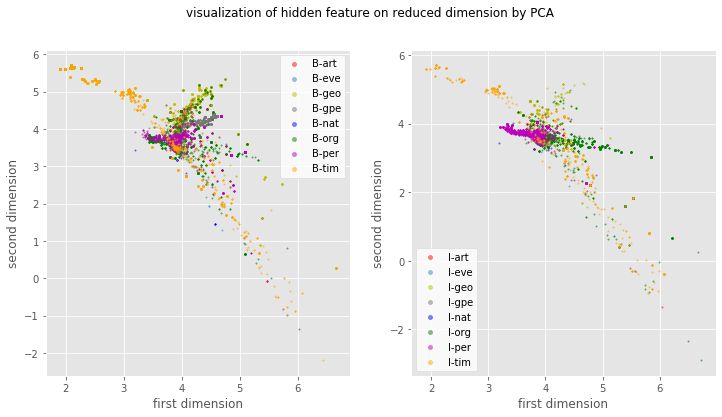

In [38]:
h = get_hidden_output_PCA(FFNN,x_test,y_test,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [39]:
# your code here
model = Sequential(name='RNN')
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len, name='Embedding'))
model.add(Dropout(drop_rate, name='Dropout'))
model.add(SimpleRNN(n_units, return_sequences=True, name='SimpleRNN'))
model.add(TimeDistributed(Dense(n_tags, activation="softmax"), name='TimeDisDense'))
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=verbose)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 38845 samples, validate on 4317 samples
Epoch 1/10
38845/38845 [==============================] - 85s 2ms/sample - loss: 0.0947 - accuracy: 0.9767 - val_loss: 0.0337 - val_accuracy: 0.9901
Epoch 2/10
38845/38845 [==============================] - 83s 2ms/sample - loss: 0.0294 - accuracy: 0.9912 - val_loss: 0.0294 - val_accuracy: 0.9912
Epoch 3/10
38845/38845 [==============================] - 84s 2ms/sample - loss: 0.0260 - accuracy: 0.9922 - val_loss: 0.0284 - val_accuracy: 0.9915
Epoch 4/10
38845/38845 [==============================] - 83s 2ms/sample - loss: 0.0243 - accuracy: 0.9927 - val_loss: 0.0282 - val_accuracy: 0.9917
Epoch 5/10
38845/38845 [==============================] - 83s 2ms/sample - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 6/10
38845/38845 [==============================] - 83s 2ms/sample - loss: 0.0221 - accuracy: 0.9934 - val_loss: 0.0272 - val_accuracy: 0.9918
Epoch 7/10
38845/38845 [==============================] -

In [40]:
# save your mode #
store_keras_model(model, 'model_RNN')

Saved model to disk


In [41]:
# run this cell to show your results #
print(model.summary())

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
Dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
SimpleRNN (SimpleRNN)        (None, 104, 100)          15100     
_________________________________________________________________
TimeDisDense (TimeDistribute (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


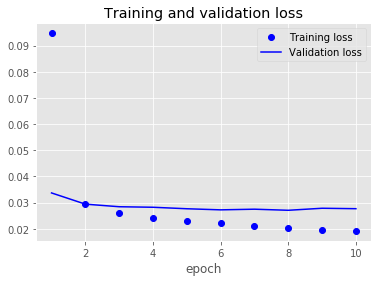

In [42]:
# run this cell to show your results #
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

Variance explained by PCA: 0.9827520127887212


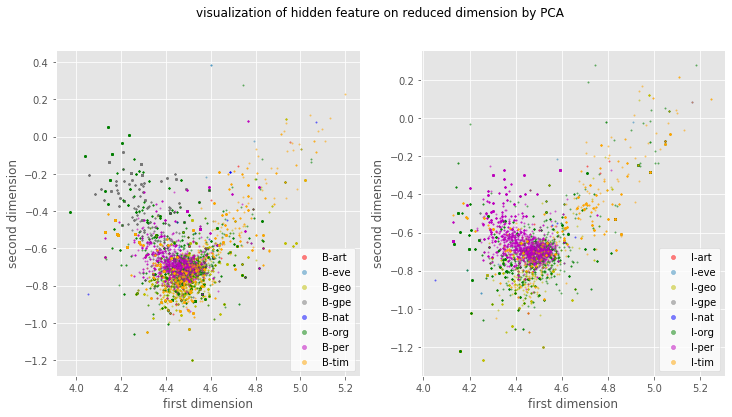

In [43]:
# your code here
RNN = load_keras_model("model_RNN")
h = get_hidden_output_PCA(RNN,x_test,y_test,1,50)
visualize_B_I(h)

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">We can see that the B tags are more scattered compared to the I tags. We can see this by how much wider the second dimension scale is for the B tags with a range of -1.2 to 0.4. However, the I tags clusters look more separated within the dense area.</p>
<p style="text-indent: 25px;">We notice that the explained variance for the Simple RNN is 0.98, where most of the variance is explained by the first two principal componenets.</p>
<p style="text-indent: 25px;"></p>
</font>

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">The GRU is a gated recurrent unit network, and LSTM variant. It is different from a simple RNN because a GRU has an update gate that decided what to pass from the previous output and a reset gate to deceide what is forgotten. The reset and update gates help the model how determine much of the past information to pass on (update gate) or forget (reset gate).</p>
<p style="text-indent: 25px;"></p>
</font>

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [44]:
# your code here
model = Sequential(name='modelGRU')
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len, name='Embedding'))
model.add(Dropout(drop_rate, name='Dropout'))
model.add(GRU(n_units, return_sequences=True, name='layerGRU'))
model.add(TimeDistributed(Dense(n_tags, activation="softmax"), name='TimeDisDense'))
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=verbose)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 38845 samples, validate on 4317 samples
Epoch 1/10
38845/38845 [==============================] - 47s 1ms/sample - loss: 0.0887 - accuracy: 0.9779 - val_loss: 0.0329 - val_accuracy: 0.9903
Epoch 2/10
38845/38845 [==============================] - 41s 1ms/sample - loss: 0.0288 - accuracy: 0.9914 - val_loss: 0.0293 - val_accuracy: 0.9913
Epoch 3/10
38845/38845 [==============================] - 41s 1ms/sample - loss: 0.0257 - accuracy: 0.9923 - val_loss: 0.0280 - val_accuracy: 0.9916
Epoch 4/10
38845/38845 [==============================] - 41s 1ms/sample - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0276 - val_accuracy: 0.9918
Epoch 5/10
38845/38845 [==============================] - 41s 1ms/sample - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0272 - val_accuracy: 0.9920
Epoch 6/10
38845/38845 [==============================] - 41s 1ms/sample - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0263 - val_accuracy: 0.9921
Epoch 7/10
38845/38845 [==============================] -

In [45]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [46]:
# run this cell to show your results #
print(model.summary())

Model: "modelGRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
Dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
layerGRU (GRU)               (None, 104, 100)          45600     
_________________________________________________________________
TimeDisDense (TimeDistribute (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


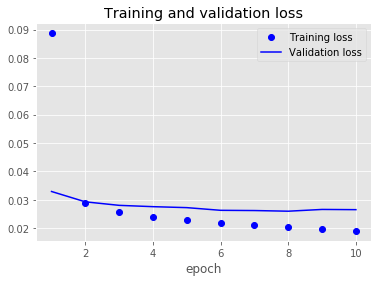

In [47]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.9646961022643222


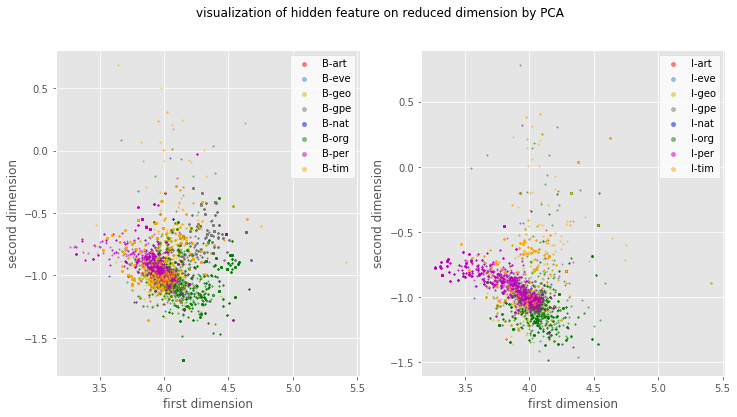

In [48]:
# your code here
mGRU = load_keras_model("model_GRU")
h = get_hidden_output_PCA(mGRU,x_test,y_test,1,50)
visualize_B_I(h)

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">The first and second dimension scales are similar from the Simple RNN. We see a clearer demarcation of the tags. We I-per tag is skewed and have a wide range of values. The B-org and I-org tags are well clustered. We still see quite a bit of overlap amoungst the tags.</p>
<p style="text-indent: 25px;">We noticed that the explained variance decrease slightly compared to the Simple RNN model.</p>
<p style="text-indent: 25px;"></p>
</font>

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">A bidirectional GRU uses two sequences, from right to left and from left to right which are combined to give a sinlge output. This can provides more context to the network, because the context of a word can change based on what was said before or after its current position in the sentence. It should improve the performance of a basic GRU model, which only uses sequences from one direction.</p>
<p style="text-indent: 25px;"></p>
</font>

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [49]:
# your code here
model = Sequential(name='modelBiGRU')
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len, name='Embedding'))
model.add(Dropout(drop_rate, name='Dropout'))
model.add(Bidirectional(GRU(n_units, return_sequences=True), name='layerBiGRU'))
model.add(TimeDistributed(Dense(n_tags, activation="softmax"), name='TimeDisDense'))
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=verbose)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 38845 samples, validate on 4317 samples
Epoch 1/10
38845/38845 [==============================] - 77s 2ms/sample - loss: 0.0727 - accuracy: 0.9816 - val_loss: 0.0284 - val_accuracy: 0.9918
Epoch 2/10
38845/38845 [==============================] - 72s 2ms/sample - loss: 0.0241 - accuracy: 0.9929 - val_loss: 0.0247 - val_accuracy: 0.9928
Epoch 3/10
38845/38845 [==============================] - 72s 2ms/sample - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0233 - val_accuracy: 0.9930
Epoch 4/10
38845/38845 [==============================] - 72s 2ms/sample - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0231 - val_accuracy: 0.9932
Epoch 5/10
38845/38845 [==============================] - 72s 2ms/sample - loss: 0.0176 - accuracy: 0.9948 - val_loss: 0.0225 - val_accuracy: 0.9934
Epoch 6/10
38845/38845 [==============================] - 72s 2ms/sample - loss: 0.0166 - accuracy: 0.9951 - val_loss: 0.0221 - val_accuracy: 0.9934
Epoch 7/10
38845/38845 [==============================] -

In [50]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [51]:
# run this cell to show your results #
print(model.summary())

Model: "modelBiGRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
Dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
layerBiGRU (Bidirectional)   (None, 104, 200)          91200     
_________________________________________________________________
TimeDisDense (TimeDistribute (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


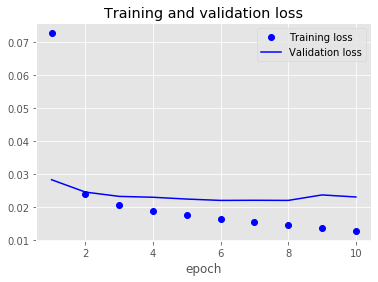

In [52]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

Variance explained by PCA: 0.814357969761071


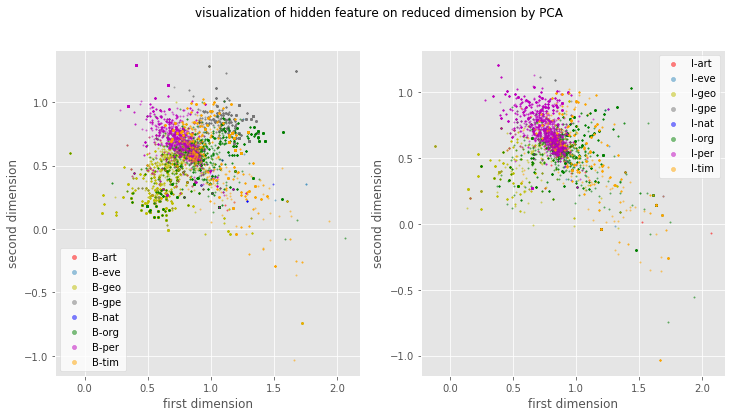

In [53]:
# your code here
mBiGRU = load_keras_model("model_BiGRU")
h = get_hidden_output_PCA(mBiGRU,x_test,y_test,1,50)
visualize_B_I(h)

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">We see that the range of the second dimension has widened to -1 to over 1.0. It means that there is better separation of the various clusters. The B tags are more scattered than the I tags.</p>
<p style="text-indent: 25px;">The explained variance dropped to 0.81 for the Bidirectional GRU model.</p>
<p style="text-indent: 25px;"></p>
</font>

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="../data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [54]:
# your code here
models = ('model_FFNN','model_RNN','model_GRU','model_BiGRU')

f1score = pd.DataFrame()
for i, name in enumerate(models):
    model = load_keras_model(name)
    p_test = model.predict(x_test)
    
    y_pred = np.empty(shape=p_test.shape, dtype = float)
    for i in range(len(p_test)):
        for j in range(len(p_test[i])):
            for k in range(len(p_test[i][j])):
                y_pred[i][j][k] = round(p_test[i][j][k])

    score = f1_score(y_test.reshape(-1,18), y_pred.reshape(-1,18), average=None)
    f1score[name] = score

f1score

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,0.000000,0.000000,0.000000,0.000000
1,0.121212,0.133333,0.133333,0.181818
2,0.793651,0.847687,0.860091,0.879191
3,0.921723,0.940192,0.942379,0.952144
4,0.076923,0.275862,0.312500,0.303030
5,0.524386,0.650616,0.664065,0.743204
6,0.671062,0.812887,0.819733,0.832521
7,0.790210,0.856248,0.859990,0.899552
8,0.000000,0.000000,0.117647,0.000000
9,0.153846,0.000000,0.000000,0.285714


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

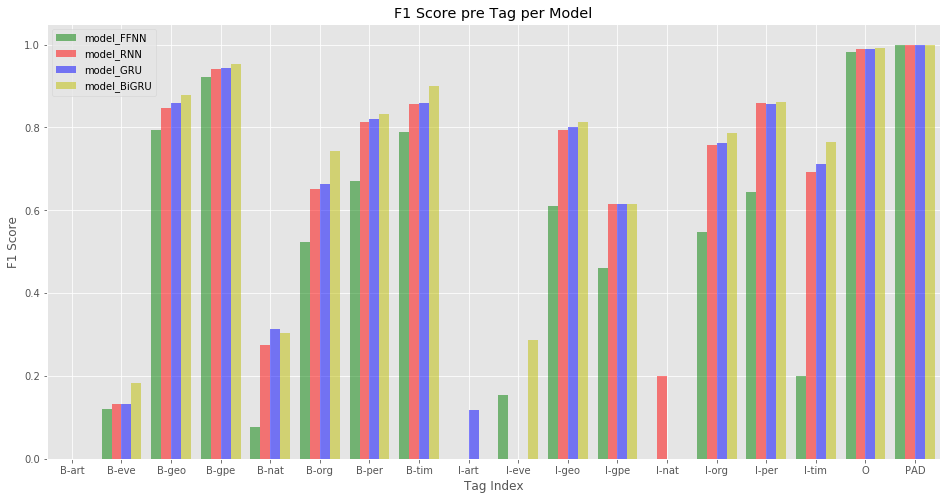

In [55]:
# your code here
pos = list(float(i) for i in range(len(f1score)))
w = 0.2

fig, ax = plt.subplots(figsize=(16,8))
plt.bar(pos,                    f1score['model_FFNN'], width=w, alpha=0.5, color='g', label='model_FFNN') 
plt.bar([p + w   for p in pos], f1score['model_RNN'], width=w, alpha=0.5, color='r', label='model_RNN')
plt.bar([p + w*2 for p in pos], f1score['model_GRU'], width=w, alpha=0.5, color='b', label='model_GRU')
plt.bar([p + w*3 for p in pos], f1score['model_BiGRU'], width=w, alpha=0.5, color='y', label='model_BiGRU')
ax.set_title('F1 Score pre Tag per Model')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Tag Index')
ax.set_xticks([p + 1.5 * w for p in pos])
ax.set_xticklabels(tags)#ax.set_xticklabels(pos)
plt.xlim(min(pos)-w, max(pos)+w*4)
plt.legend(['model_FFNN', 'model_RNN', 'model_GRU', 'model_BiGRU'])
plt.show()

**3.3** Briefly discuss the performance of each model

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">We can see that the BiGRU performs the best for most of the tags with exception of the B-art, I-art, and I-nat. The Simple RNN and GRU are similar and only slightly worse than the BiGRU model. The FFNN has the lowest F1 scores and in some cases, such as B-nat and I-tim, it is considerably lower. Each model progressively adds more context to each word of the sentence and we see that in the F1 scores.</p>
<p style="text-indent: 25px;"></p>
</font>

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="../data/B_art.png" alt="drawing" width="600"/>

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">The B-art has an F1 score of 0 for all models and I-art has an F1 score of 0 except for the GRU.</p>
<p style="text-indent: 25px;"></p>
</font>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [56]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [57]:
# your code here
# here we are trying yo find 20 sentences with B-art and I-art.
bsents = data.iloc[np.where(data['Tag'] == "B-art" )]
sents = bsents['Sentence #'].unique()
ldata = pd.DataFrame(columns = bsents.columns)
dsents = pd.DataFrame()

k = 0
for i in sents:
    dsents = data.iloc[np.where(data['Sentence #'] == i )]
    ifound = 'N'
    for t in dsents['Tag']:
        if (t == "I-art"):
            ifound = 'Y'
        if (ifound == 'Y'):
            ldata = ldata.append(data.iloc[np.where(data['Sentence #'] == i )]) 
            k = k+1
        if (k > 20):
            break

In [58]:
# your code here
# here we are preparing the data and format
lsentences = []
lsentence = []
print(type(lsentence))

lsentencenum = ldata.iloc[0]['Sentence #']
print(lsentencenum)
for i in ldata.itertuples():
    if lsentencenum == i[1]:
        t = (i[2],i[4] )
        lsentence.append(t)
    else:
        lsentences.append(lsentence)
        lsentencenum = i[1]
        lsentence = []
        t = (i[2],i[4] )
        lsentence.append(t)

lX =[]
for i in lsentences:
    w =  [word2idx[j[0]] for j in i]
    lX.append(w)

lX = pad_sequences(lX, maxlen=max_len, padding = 'post', value = word2idx['ENDPAD'], dtype='int' )

lY =[]
for i in lsentences:
    t =  [tag2idx[j[1]] for j in i]
    lY.append(t)
lY = pad_sequences(lY, maxlen=max_len, padding = 'post', value = tag2idx['PAD'], dtype='int' )

<class 'list'>
Sentence: 12


In [59]:
# your code here
# Here we are creating a dataframe with a sentence and its words, tags, and tag predictions.
ytag = pd.DataFrame()
m = 1
g = len(lX[m])
ytag['Word'] = list(idx2word[w] for w in lX[m])

y_tag = np.empty(shape=lY[m].shape[0], dtype = int)
for i in range(lY[m].shape[0]):
    y_tag[i] = lY[m][i]
ytag['y_true'] = [idx2tag[i] for i in y_tag]

for i in range(lY[m].shape[0]):
    y_tag[i] = lY[m][i]
ytag['baseline'] = list([idx2tag[i] for i in baseline[y_tag]])

In [60]:
# your code here
# continued from above
models = ('model_FFNN','model_RNN','model_GRU','model_BiGRU')

for i, name in enumerate(models):
    model = load_keras_model(name)
    p_test = model.predict_classes(lX)
    y_cat = np.argmax(to_categorical(lY, len(tags)), axis=2)
    
    y_tag = np.empty(shape=y_cat[0].shape[0], dtype = int)
    for i in range(y_cat[0].shape[0]):
        #print(y_cat[0][i].max())
        y_tag[i] = y_cat[0][i].max()
        
    ytag[name] = [idx2tag[i] for i in y_tag]

ytag[0:16].style.apply(highlight_errors, axis=1)

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,and,O,O,O,O,O,O
1,Ram,B-art,O,B-org,B-org,B-org,B-org
2,vehicles,O,O,I-org,I-org,I-org,I-org
3,.,O,O,O,O,O,O
4,Chrysler,B-org,O,O,O,O,O
5,plans,O,O,B-gpe,B-gpe,B-gpe,B-gpe
6,to,O,O,O,O,O,O
7,build,O,O,O,O,O,O
8,its,O,O,O,O,O,O
9,new,O,O,O,O,O,O


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [61]:
# your code here
np.random.seed(123)
tf.random.set_seed(456)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.01)

n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = 'rmsprop'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

batch_size = 32
epochs = 10
validation_split = 0.01
verbose = 1

model = Sequential(name='modelGNU')
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len, name='Embedding'))
model.add(Dropout(drop_rate, name='Dropout'))
model.add(BatchNormalization(axis=1, epsilon=0.001, name='BatchNorm'))
model.add(Bidirectional(GRU(n_units, return_sequences=True), name='layerBiGRU'))
model.add(TimeDistributed(Dense(n_tags, activation='softmax'), name='TimeDisDense'))
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=verbose)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.2f%%' % (scores[1]*100))

name = 'modelGNU'
p_test = model.predict(x_test)
    
y_pred = np.empty(shape=p_test.shape, dtype = float)
for i in range(len(p_test)):
    for j in range(len(p_test[i])):
        for k in range(len(p_test[i][j])):
            y_pred[i][j][k] = round(p_test[i][j][k])

score = f1_score(y_test.reshape(-1,18), y_pred.reshape(-1,18), average=None)
f1score[name] = score

f1score

Model: "modelGNU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
Dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
BatchNorm (BatchNormalizatio (None, 104, 50)           416       
_________________________________________________________________
layerBiGRU (Bidirectional)   (None, 104, 200)          91200     
_________________________________________________________________
TimeDisDense (TimeDistribute (None, 104, 18)           3618      
Total params: 1,854,184
Trainable params: 1,853,976
Non-trainable params: 208
_________________________________________________________________
Train on 47003 samples, validate on 475 samples
Epoch 1/10
47003/47003 [==============================] - 92s 2m

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,model_FFNN,model_RNN,model_GRU,model_BiGRU,modelGNU
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.121212,0.133333,0.133333,0.181818,0.666667
2,0.793651,0.847687,0.860091,0.879191,0.875000
3,0.921723,0.940192,0.942379,0.952144,0.977049
4,0.076923,0.275862,0.312500,0.303030,1.000000
5,0.524386,0.650616,0.664065,0.743204,0.720988
6,0.671062,0.812887,0.819733,0.832521,0.824903
7,0.790210,0.856248,0.859990,0.899552,0.908602
8,0.000000,0.000000,0.117647,0.000000,0.000000
9,0.153846,0.000000,0.000000,0.285714,1.000000


**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*<br />
<font color='blue'>
<p style="text-indent: 25px;"></p>
<p style="text-indent: 25px;">We see improvements in the F1 scores of several tags that had very poor F1 scores using previous models, such as 4 (B-nat). First, we increased the amount of data to train by reducing the percent of the data in the test and validation datasets. This included those words with fewer occurences so we can adequately train the model. The downside for this is that your test validation may not be as robust due to the remaining records in the test set not being very diverse in vocabulary and context. This may also mean that the test data may not be that different from the training data.</p>
<p style="text-indent: 25px;">Secondly, we used a Batch normalization layer that normalizes the output of a previous layer by subtracting the batch mean and dividing by the batch standard deviation, which helps increase the stability of a neural network. </p>
<p style="text-indent: 25px;"></p>
</font>